# Measuring fringe separation

_Note: this document uses the programming language Python to generate data and plot graphs. You can just skip the "code cells" if you don't know Python. Python is taught in PHYS3112._

Suppose that you want to measure the separation in millimetres between two fringes in an interference pattern. This notebook explores ways of doing this, and deriving an error estimate for the result.

To begin with, let's generate some representative data showing measurements of fringe intensity versus distance.

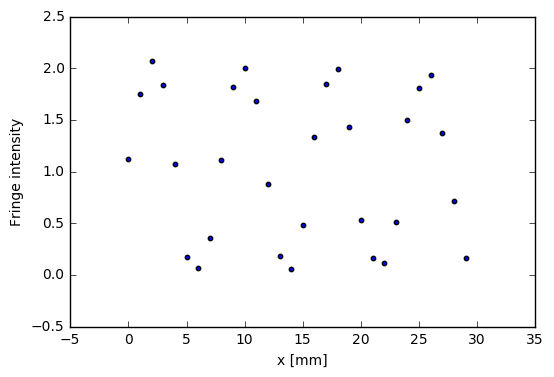

In [39]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Seed the random number generator, so that we always
# get the same numbers.

np.random.seed(0)

# Here is the array of distances at which we measure the
# fringe intensity. We will make 30 measurements, at
# integral millimeters.

x = np.array(np.arange(30))

# Generate fake intensity data, with amplitude 1.0,
# peak spacing of 2Pi/0.8 mm, and Gaussian noise with
# amplitude 0.07 added for realism.

y = 1.0 + np.sin(0.8 * x) + \
    np.random.normal(loc=0.0, scale=0.07, size=x.size)

# Plot the "measurements".

plt.scatter(x, y, s = 10)
plt.xlabel("x [mm]")
plt.ylabel("Fringe intensity")
plt.show()


For our first attempt at determining the fringe spacing, we will estimate the position of the fringe peaks to the nearest mm by inspection of the plot. The following table shows these estimates:

|Fringe number|Peak position|Distance to next peak|
|-------------|-------------|---------------------|
|      1      |       2     |8|
|2|10|8|
|3|18|8|
|4|26||

The average peak separation is 8mm, but what error should we associate with this? __Note: don't be tempted to assume that the FWHM of the fringe intensity (which is about 4) is indicative of the error in the peak position! It is unrelated - you can measure the peak position much more accurately than that.__

All of the individual determinations of the peak separation in the table above are the same, so we don't get much of a clue from them. If we assume that each estimate of a peak position has an error of 0.5mm, then each separation will have an error of 0.7mm (i.e., $\sqrt2\times0.5$, by adding the errors in quadrature). And if you then average 3 measurements of the separation, you reduce the error by roughly $\sqrt3$. __So our final result is $8.0\pm0.4$__.

We can do somewhat better by attempting to guess the peak positions to better than 1mm. We do this by noting that if the two intensity readings on either side of a peak are the same, then the peak position is likely to be midway between the two. By inspection, you might guess the following peak positions:

|Fringe number|Peak position|Distance to next peak|
|-|-|-|
|1|2.1|7.8|
|2|9.9|7.8|
|3|17.7|7.9|
|4|25.6||

We can now average the three peak separations (7.8, 7.8, 7.9) and obtain our best estimate of 7.83. But what error to associate with this estimate? With only three measurements, and with such limited resolution, a formal calculation of the standard error on the mean will be very dependent on the individual measurements. In this case it is probably best just to look at the data and have a guess. 0.05 sounds about right. So __our estimate of the peak separation is $7.83\pm0.05$__, which is a considerable improvement over our first attempt.

Note that we would have obtained exactly the same value if we had just taken the first and last peak positions and divided by the number of peaks (i.e., $(25.6-2.1)/3 = 7.83$, to three significant figures). This isn't surprising since, mathematically, averaging all the individual peak separations simply cancels out all the intermediate measurements. So we may as well have just measured the first and last peaks, and divided by 3. In fact, this is the best approach if you want to rapidly arrive at a good estimate: just measure two peaks separated by as far as possible, and divide by the number of fringes (plus 1) between them.

We can estimate the error in this second method by determining how accurately we can measure each peak position. Suppose that we can estimate a peak to 0.2mm, then the error in measuring the distance between any two peaks is $\sqrt2\times0.2 = 0.28$. The factor of $\sqrt2$ comes from adding the errors in quadrature, since they are independent (i.e., if we measure one peak a little too far to the left, it makes no difference to our estimate of another peak). Finally, we have to divide the error by 3, since we are measuring 3 times the peak separation in our case, __so we arrive at a final estimate of $7.83\pm0.09$__. Note that the error estimate is almost twice what we had before, but this isn't a major concern since we are clearly making guesses here.

But we can do better still!

One improvement would be to do a better job of estimating the peak positions. Rather than just guessing from the plot, we could fit a parabola to the three measuments near a peak, and find the top of the parabola. We could also measure the peak troughs as well. 

But what about all the other measurements we made? Surely each one of them contributes some information to our knowledge of the peak separation? The next step up in data analysis is to fit a function to the data, and optimize the function parameters (one of which will be the peak separation) until we obtain the best fit to all the data points.

And that is what we do with the following python code:

Actual peak separation 7.854; fitted peak separation 7.848 +/- 0.012


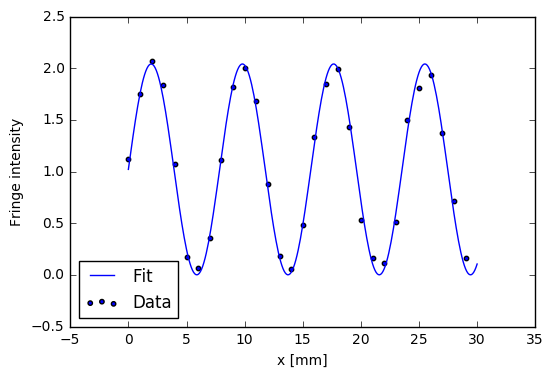

In [38]:
# Import the optimization code from scipy.

from scipy import optimize

# Define a function that we will fit to the data. The function
# takes an array of values, x, at which to calculate its values, 
# and parameters, a, b, that we wish to fit.

def func(x, a, b):
    return a * (1.0 + np.sin(b * x))

# Fitting the function to the data is now as simple as one line, where
# [0.9, 0.7] is an initial guess of the parameters:

pars, pars_covariance = optimize.curve_fit(func, x, y, [0.9, 0.7])

# And the one-sigma variances in the parameters are:

oneSigmaVariances = np.sqrt(np.diag(pars_covariance))

# Convert our estimate of the angular frequency to period, 
# and calculate the error. Compare with the actual period.

actualPeriod = 2 * np.pi / 0.8
estimatedPeriod = 2 * np.pi / pars[1]
error = estimatedPeriod * oneSigmaVariances[1] / pars[1]

print("Actual peak separation {:.3f}; fitted peak separation {:.3f} +/- {:.3f}".format(actualPeriod, estimatedPeriod, error))

# Plot the data, and superimpose the fit (sampled at 
# finer resolution than the data, so we have a smooth curve).

plt.scatter(x, y, s = 10, label='Data')

# Here we choose a new array of x values, with ten times as many points.

xfine = np.linspace(0, 30, num=301)
plt.plot(xfine, func(xfine, pars[0], pars[1]), label='Fit')
plt.xlabel("x [mm]")
plt.ylabel("Fringe intensity")
plt.legend(loc='lower left')
plt.show()


This is a very impressive result! Note that the error is about a factor of 10 better than what we were able to achieve by estimating the peak positions by eye. Also, it is comforting that our fitted result is within one sigma of the correct value.

There are further refinements we could make, e.g., we can tell the python optimization routine what the errors on our individual data points are, so that the fit can take these into account.

## The effect of an envelope function

The fringe data that we generated assumes that the sine amplitude remains constant with fringe number. In fact, the amplitude will drop off as you move away from the central fringe. This will bias the visual estimate of the peak position: the peak will appear to be a bit closer to the central fringe. You can take this into account with the computer fitting routine, by simply adding another parameter to the fit.

Michael Ashley 16 Jun 2019